## Preparation

In [ ]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Ex. 1 Gradient descent

## Preparation

In [ ]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

## Ex. 1.1 MSELoss realization

In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        # Очевидно, пользуемся указанной формулой: с помощью dot перемножаем массив данных на
        # вектор весов, вычитаем вектор ответов, ищем от него норму (np.linalg.norm) и
        #возводим в квадрат. Для получения ответа делим на кол-во строк в y
        return ((np.linalg.norm(np.dot(X, w)-y)) ** 2) / y.shape[0]

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        # Опять же пользуемся указанной формулой. Туда-сюда все понятно, пояснять
        # думаю не нужно
        return 2 * (np.dot(X.T, (np.dot(X, w) - y))) / y.shape[0]

In [ ]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


## Ex. 1.2 Gradient descent realization

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    # создаем массив весов на каждом шаге с помощью генератора, моржового оператора
    # (для запоминания предыдущего вектора весов) и формулы:
    #             $w^{t} = w^{t - 1} - \eta * \nabla Q(X, y, w^{t - 1})$
    ans = [w_init := w_init - lr * loss.calc_grad(X, y, w_init) for i in range(n_iterations)]
    return ans

In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))
print("Как по мне - красота")

155.2625821435192
0.8670644395649494
Как по мне - красота


## Ex. 1.3 Gradient descent trajectories (visualization)

In [ ]:
# Я чуть чуть поправил формулу, чтобы выводились размер шага, размер batch'а и
# коэффициент убывания. Еще я ограничил значения xlim и ylim, потому что с ними
# большие значения шага выглядели не показательно

def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss, name1="", name2 = "", name3 = ""):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    #plt.figure(figsize=(10, 5))
    t = "GD trajectory for first step " + str(name1)
    if name2 != "":
      t += " for batch " + str(name2)
    if name3 != "":
      t += " for p " + str(name3)
    plt.title(t)
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(-0.6, 1)
    plt.ylim(-1.5, 1.5)
    plt.gca().set_aspect("equal")
    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    #visualize the level set
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

In [ ]:
from matplotlib.gridspec import GridSpec

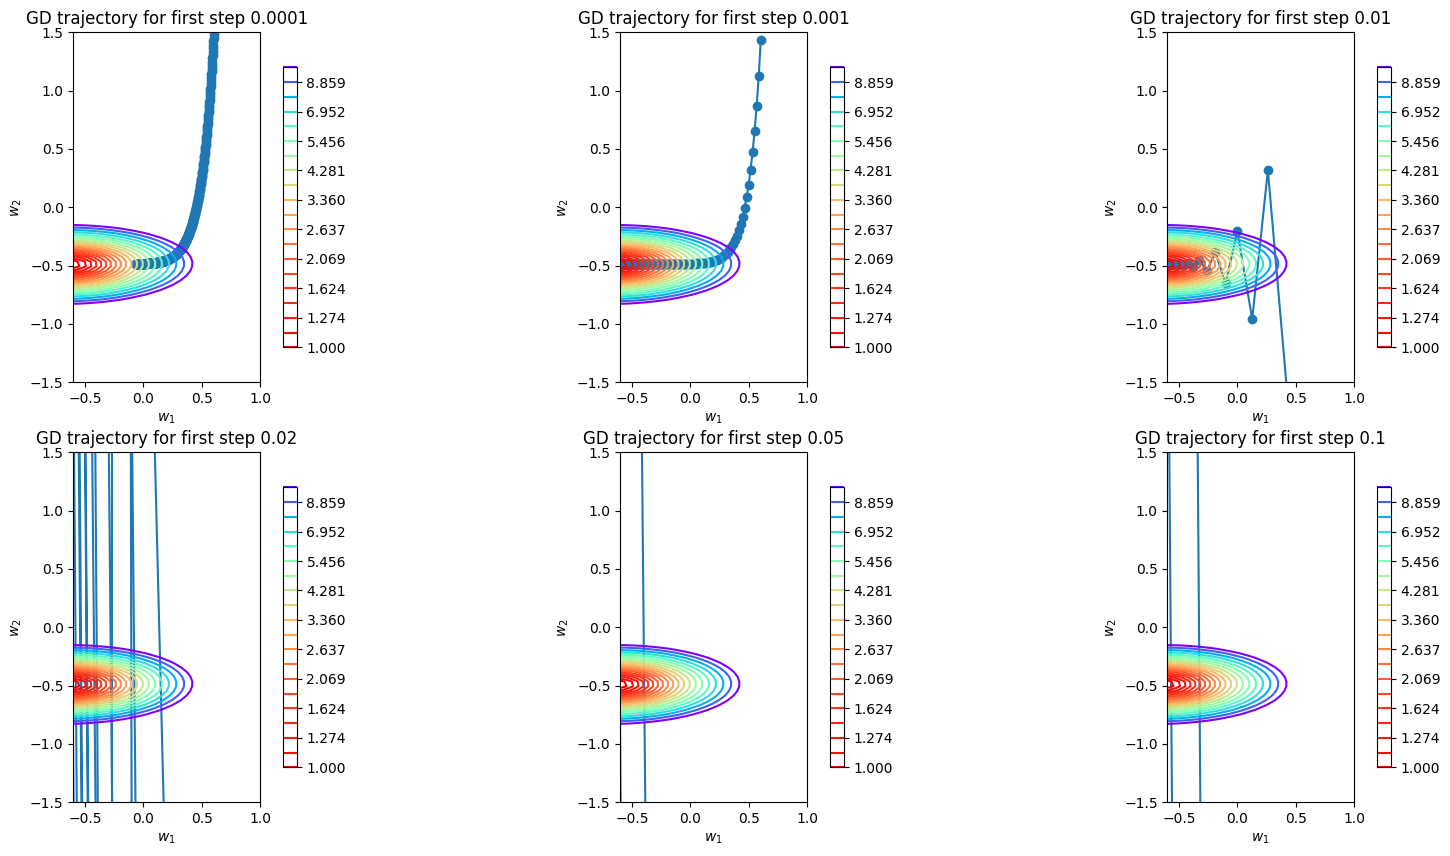

In [ ]:
# массивом зададим различные значения шага
a = [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1]

# вывожу графики
fig = plt.subplots(figsize=(20, 10))
grid = GridSpec(nrows = 2, ncols = 3, figure=fig)

for i in range(6):
  plt.subplot(grid[i // 3, i % 3])
  plot_gd(gradient_descent(w_init, X, y, loss, a[i], 500), X, y, loss, a[i])
plt.show()

In [ ]:
# нетрудно увидеть, что при очень маленьких шагах значения лосса максимально правильно
# идут к минимуму, но сами вектора весов почти равны друг другу. При небольшом
# увеличении шага значения лосса все равно идет в верную сторону (золотая середина).
# Еще увеличив шаг вектор весов начинает меняться слишком сильно, из-за чего минимум
# постоянно "перескакивается". Кринж короче.

## Ex. 1.4 Stochastic gradient descent

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
  # Здесь генератором воспользоваться проблемно, поэтому создадим массив векторов
  # на кажом шаге (пока там хранятся только начальные значения)
  ans = [w_init]

  # В массиве на каждом шаге выбираем случайные числа, которые будут индексами
  # для выделения случайных строк из X и у в размере batch_size. Далее все аналогично
  # обычному градиентому спуску.
  for i in range(1, n_iterations):
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    w_init = w_init - lr * loss.calc_grad(X[batch_indices], y[batch_indices], w_init)
    ans.append(w_init)
  return ans

## Ex. 1.5 Stochastic gradient descent trajectories (visualization)

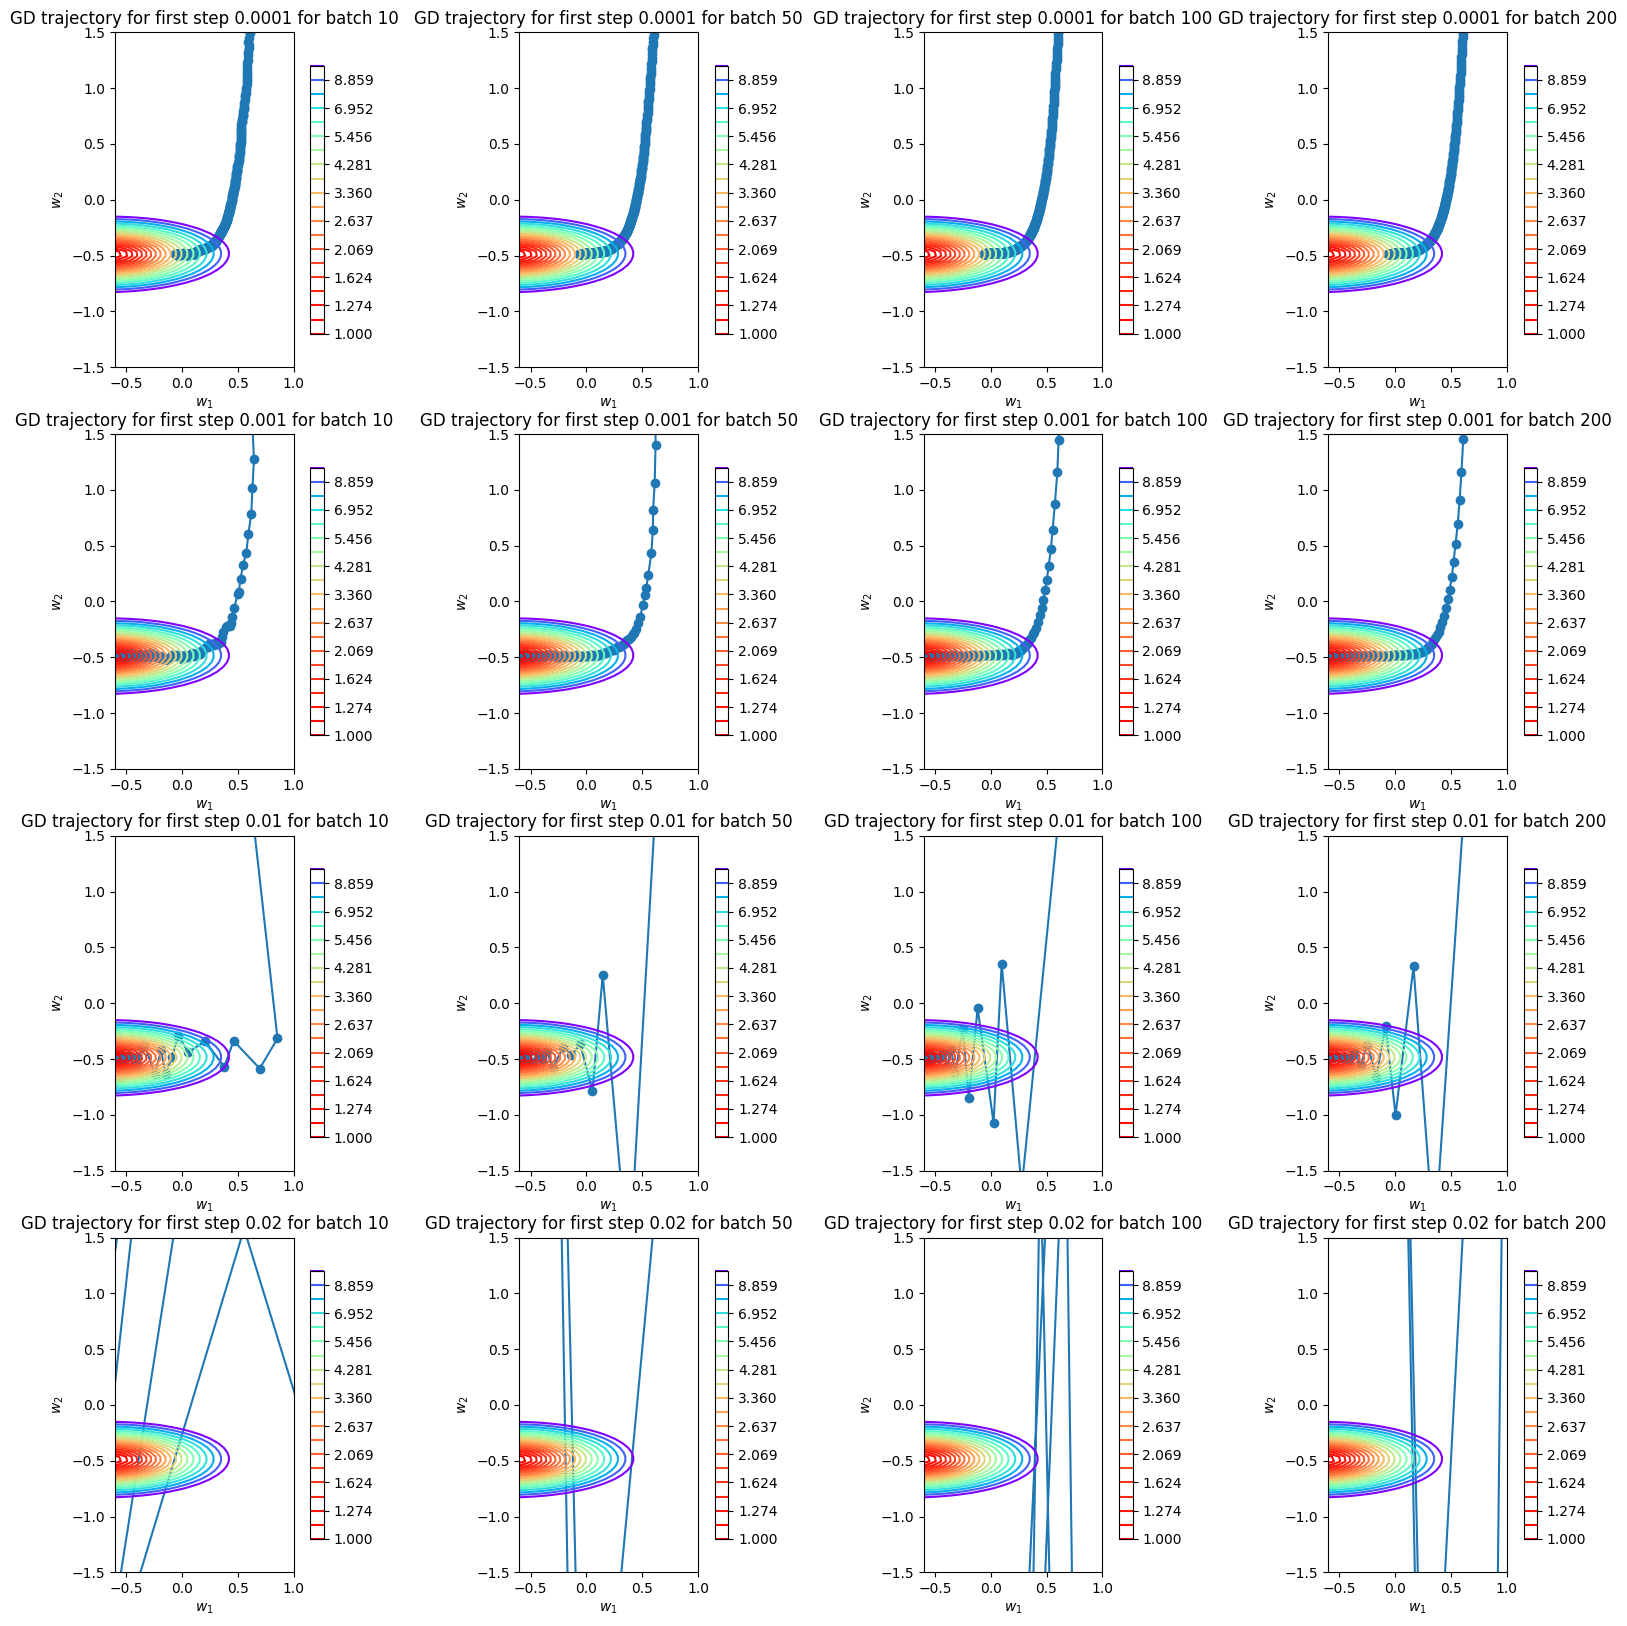

In [ ]:
# различные значения шага (взял хоть сколько-то логичные значения, которые не
# сильно портили график в прошлом задании)
a = [0.0001, 0.001, 0.01, 0.02]
# различные размеры batch
b = [10, 50, 100, 200]

# Аналогично выводим графики
fig = plt.subplots(figsize=(20, 20))
grid = GridSpec(nrows = 4, ncols = 4, figure=fig)

for i in range(4):
  for j in range(4):
    plt.subplot(grid[i, j])
    plot_gd(stochastic_gradient_descent(w_init, X, y, loss, a[i], b[j], 500), X, y, loss, a[i], b[j])
plt.show()

In [ ]:
# Заметно, что когда мы считаем градиент не по всей выборке, а только по
# по ее части, график становиться немного прерывистым, что логично, ведь
# градиент по части неравен градиенту по всем данным. При этом чем больше
# batch_size, тем траекторее "вернее". Различные размеров шагов же влияют
# на графики аналогично обычному градиентному спуску.

## Ex. 1.6 Stochastic gradient descent with fading step

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
  # Все буквально то же самое, но с небольшим изменением формулы
  ans = [w_init]
  for i in range(n_iterations):
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    w_init = w_init - (lr) * (1 / (1 + i)) ** p * loss.calc_grad(X[batch_indices], y[batch_indices], w_init)
    ans.append(w_init)
  return ans

## Ex. 1.7 Stochastic gradient descent with fading step (visualization)

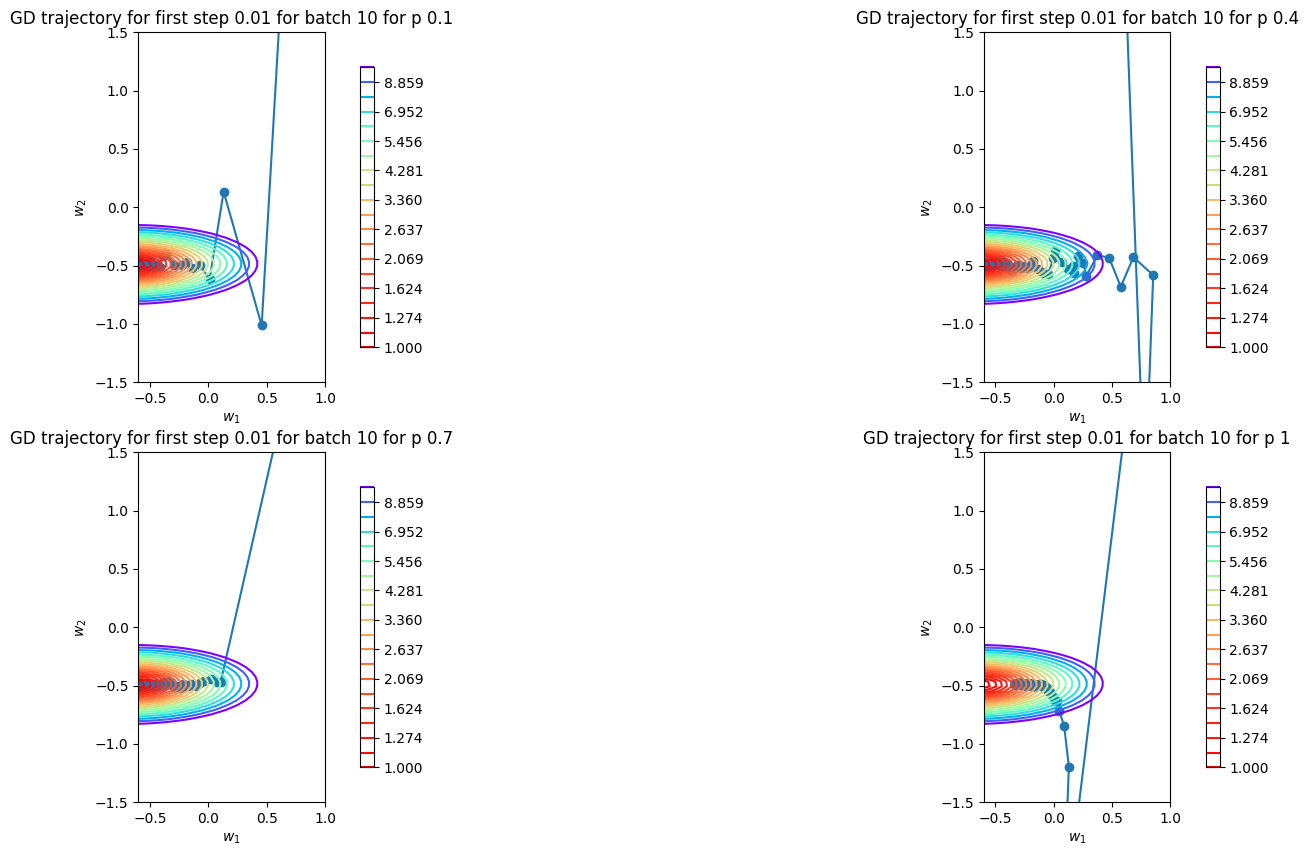

In [ ]:
# Различные значения p для затухающего шага
a = [0.1, 0.4, 0.7, 1]

# Аналогично рисуем
fig = plt.subplots(figsize=(20, 10))
grid = GridSpec(nrows = 2, ncols = 2, figure=fig)

for i in range(4):
  plt.subplot(grid[i // 2, i % 2])
  plot_gd(stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, a[i], 500), X, y, loss, 0.01, 10, a[i])
plt.show()

In [ ]:
# Как это не удивительно, затухающий шаг уменьшает размер шага. С ростом p график
# быстрее становиться похож на "верный", так как при больших значениях p шаг уменьшается
# быстрее из-за чего шанс "перепрыгнуть" локальный (хотя раз мы считаем MSE, то глобальный)
# минимум становится меньше. Однако большие p сильно увеличивают количество итераций,
# что не очень хорошо, поэтому стоит отдавать предпочтение отрезку [0.3; 0.7] (по
# крайней мере здесб это, кажется, так)

## Ex. 1.8 Comparison GD and SGD

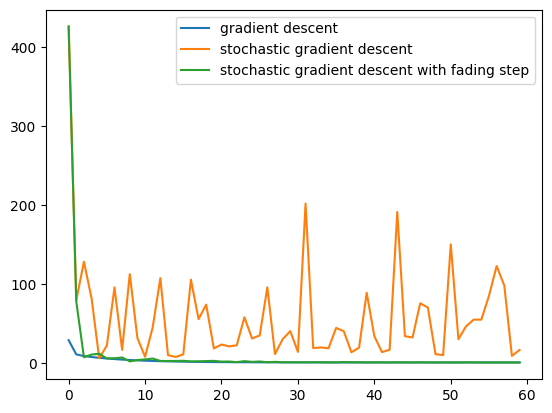

In [ ]:
a = [loss.calc_loss(X, y, gradient_descent(w_init, X, y, loss, 0.005, 1000)[i]) for i in range(60)]
b = [loss.calc_loss(X, y, stochastic_gradient_descent(w_init, X, y, loss, 0.005, 10, 1000)[i]) for i in range(60)]
c = [loss.calc_loss(X, y, stochastic_gradient_descent(w_init, X, y, loss, 0.005, 10, 0.1, 1000)[i]) for i in range(60)]

plt.plot(a, label = "gradient descent")
plt.plot(b, label = "stochastic gradient descent")
plt.plot(c, label = "stochastic gradient descent with fading step")
plt.legend()

plt.show()

In [ ]:
# Преимущества стохастического градиентного спуска (обычного) на рисунке вообще не видно и на
# то есть две причины. Во-первых, значение шага здесь слишком большое, лучше взять его
# меньше. Во-вторых же, главное преимущество стохастического градиентного спуска над
# обычным заключается в его скорости. Считая градиент лишь по 10 объектам, а не по 300,
# мы значительно экономим время (здесь я этого не оставил, но я игрался с time и на 10000
# шагов время выполнения обычного градиентного спуска было около 14 секунд, а вот
# стохастического всего 3). Если же говорить про стохастический градиентый спуск с
# затухающим шагом, то мы видим, что его стремление к нулю больше, что логично: в начале он
# делает большие шаги в примерно верную сторону, дальше они уменьшаются, но так как мы уже
# близко к нулевому лоссу это помогает хорошо "уточнить" результат.

# Ex. 2 Linear regression

## Ex. 2.1 Fit and Predict methods

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        # Генерируем случайный вектор нужного размера (количество признаков)
        w_init = np.random.randint(-10, 10, X.shape[1])

        # Вызываем функцию градиента, написанную ранее, и берем последний элемент
        # вернувшегося массива
        self.w = gradient_descent(w_init, X, y, self.loss, self.lr, 1000)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        # Возвращаем матричное произведение объектов на веса - это и есть таргет
        return np.dot(X, self.w)

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [ ]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

## Ex. 2.2 Standarting data

In [ ]:
X_raw

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


In [ ]:
# Очевидно, что index - ненужный столбец, удалим его
X_raw.drop('index', axis=1, inplace=True)

# Посчитаем количество пропусков
X_raw.isna().sum()

# Они есть, значит будем заполнять

0      0
1     37
2      0
3      0
4      0
5      2
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     4
19     4
20     0
21     2
22     2
23     0
24     0
dtype: int64

In [ ]:
# Давайте посмотрим на столбцы, где количество уникальных значений небольшое (8)
for i in range(X_raw.shape[1]):
  if (X_raw.loc[:, i].value_counts().shape[0] <= 8):
    print(X_raw.loc[:, i].value_counts())

# Видим, что все такие столбцы - это столбцы object, которые и так очевидно категориальные.
# Но нулевой стобец числовой и имеет всего 6 уникальных значений, давайте его тоже
# считать категориальным

0
 0    65
 1    52
 2    32
 3    27
-1    22
-2     3
Name: count, dtype: int64
3
gas       181
diesel     20
Name: count, dtype: int64
4
std      165
turbo     36
Name: count, dtype: int64
5
four    113
two      86
Name: count, dtype: int64
6
sedan          94
hatchback      68
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64
7
fwd    118
rwd     75
4wd      8
Name: count, dtype: int64
8
front    198
rear       3
Name: count, dtype: int64
14
ohc      145
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
Name: count, dtype: int64
15
four      157
six        24
five       10
two         4
eight       4
three       1
twelve      1
Name: count, dtype: int64
17
mpfi    92
2bbl    64
idi     20
1bbl    11
spdi     9
4bbl     3
mfi      1
spfi     1
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Выделим числовые признаки (кроме 0 столбца и заполним пропуски медианой)
X_raw[X_raw.select_dtypes(include=[np.number]).columns[1:]] = X_raw.select_dtypes(include=np.number).loc[:, 1:].apply(lambda x: x.fillna(int(x.median())), axis=0)

# Единственные два категориальных признака, где есть пропуски, мы заполним модой
X_raw[5].fillna(X_raw[5].mode()[0], inplace=True)
X_raw[0].fillna(X_raw[0].mode()[0], inplace=True)

# Пересчитаем пропуски
X_raw.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
dtype: int64

In [ ]:
# Стандартизируем данные с помощью StandartScaler (все числовые стобцы, кроме 0)
scaler = StandardScaler()
col = X_raw.select_dtypes(include=[np.number]).columns[1:]
X_raw[col] = scaler.fit_transform(X_raw[col])

In [ ]:
# Кодируем категориальные столбцы - выделяем из таблицы столбцы с типом object, добавляем
# нулевой столбце, испольщуем OneHotEncoder для создания кодированных данных
enc = OneHotEncoder(sparse_output=False)
col = X_raw.select_dtypes(include=object).columns
categ = pd.DataFrame(enc.fit_transform(X_raw[np.append(col, 0)]))
categ.columns = enc.get_feature_names_out()

# Соединяем старую таблицу с новой, удаляем старые категориальные столбцы
X_raw = X_raw.join(categ)
col = X_raw.select_dtypes(include=object).columns
X_raw.drop(columns=np.append(col, 0), axis=1, inplace=True)

In [ ]:
X_raw

,1,9,10,11,12,13,16,18,19,20,...,x9_mfi,x9_mpfi,x9_spdi,x9_spfi,x10_-2,x10_-1,x10_0,x10_1,x10_2,x10_3
0,-0.178306,-1.685107,-0.439409,-0.853460,-2.034081,-0.014858,0.075389,0.537547,-1.802078,-0.291435,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.178306,-1.685107,-0.439409,-0.853460,-2.034081,-0.014858,0.075389,0.537547,-1.802078,-0.291435,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.178306,-0.710103,-0.244152,-0.185597,-0.559713,0.518080,0.606234,-2.373677,0.687715,-0.291435,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.351431,0.165748,0.195176,0.148335,0.218425,-0.423766,-0.431327,-0.494279,0.467101,-0.041121,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.351431,0.099646,0.195176,0.243744,0.218425,0.520017,0.220165,-0.494279,0.467101,-0.541748,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.802689,1.702619,1.187733,1.436357,0.709881,0.768075,0.340812,1.679926,-0.320808,-0.166278,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197,-0.802689,1.702619,1.187733,1.388653,0.709881,0.956057,0.340812,1.679926,-0.320808,-0.366529,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
198,-0.802689,1.702619,1.187733,1.436357,0.709881,0.884353,1.112950,0.942907,-1.203267,-0.341497,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
199,-0.802689,1.702619,1.187733,1.436357,0.709881,1.281633,0.437329,-1.157596,0.467101,3.212954,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
# Разобьем таблицу на обучающую и тестовую выборки. Для равномернойсти воспользуемся
# KBinsDicretizer
bins = KBinsDiscretizer(n_bins=7, encode='ordinal')
razd = pd.DataFrame(bins.fit_transform(np.array(y).reshape(-1, 1)))
x_train, x_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=1, stratify=razd)

## Ex. 2.3 Linear Regression (MSE Loss)

In [ ]:
# Обучим регресию с MSE Loss
linear = LinearRegression(MSELoss(), 0.07)
linear.fit(x_train, y_train)

## Ex. 2.4 Losses on Linear Regression (MSE Loss)

In [ ]:
from sklearn.metrics import mean_squared_error
print("MSE на обучающей выборке: ", mean_squared_error(y_train, linear.predict(x_train)),
      "\nMSE на тестовой выборке:  ", mean_squared_error(y_test, linear.predict(x_test)))

MSE на обучающей выборке:  2024384.405576786 
MSE на тестовой выборке:   10061610.291145967


## Ex. 2.5 Linear Regression (MSE 2 Loss)

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """

        # Буквально переписываем формулу (учитывая, что не треюуется считать константный признак)
        return (np.linalg.norm(X.dot(w) - y) ** 2) / y.shape[0] + self.coef * w[w.shape[0] - 1].dot(w[w.shape[0] - 1])

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # Опять же переписываем формулу
        w_dop = w
        w_dop[w.shape[0] - 1] = 0
        return 2 * X.T.dot(X.dot(w) - y) / y.shape[0] + 2 * self.coef * w_dop

In [ ]:
linear = LinearRegression(MSEL2Loss(0.05), 0.07)
linear.fit(x_train, y_train)

## Ex. 2.6 Losses on Linear Regression (MSE 2 Loss)

In [ ]:
from sklearn.metrics import mean_squared_error

print("MSE на обучающей выборке: ", mean_squared_error(y_train, linear.predict(x_train)),
      "\nMSE на тестовой выборке:  ", mean_squared_error(y_test, linear.predict(x_test)))

# Чуть чуть выровняллось (хотя бы не в 5 раз разница)

MSE на обучающей выборке:  4290179.707194999 
MSE на тестовой выборке:   11735723.44132884


## Ex. 2.7 Linear Regression (Huber Loss)

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        # Считаем массив разниц наших текущих ответов и правильных
        sum = np.dot(X, w) - y

        # Выделяем ответы, которые подходят под условие и редактируем по формуле
        np.where(sum ** 2 < self.eps ** 2, (sum ** 2) / 2, (self.eps * (np.absolute(sum) - self.eps / 2)))

        # Делим на количество элементов
        return sum / y.shape[0]

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # Считаем массив разниц наших текущих ответов и правильных
        sum = np.dot(X, w) - y

        # Выделяем ответы, которые подходят под условие и редактируем по формуле
        np.where(sum ** 2 < self.eps ** 2, sum, self.eps * np.sign(sum))

        # Пользуясь данной формулой возвращаем ответ
        return (np.sum(X * sum.reshape(-1, 1), axis=0) / y.shape[0]).T

In [ ]:
linear = LinearRegression(HuberLoss(3500), 0.05)
linear.fit(x_train, y_train)

## Ex. 2.8 Losses on Linear Regression (Huber Loss)

In [ ]:
print("MSE на обучающей выборке: ", mean_squared_error(y_train, linear.predict(x_train)),
      "\nMSE на тестовой выборке:  ", mean_squared_error(y_test, linear.predict(x_test)))
# Как будто стало лучше, ошибка на тесте уменьшилась на 200К

MSE на обучающей выборке:  2614692.6269290918 
MSE на тестовой выборке:   9898677.41776912


# Ex. 3 MEME

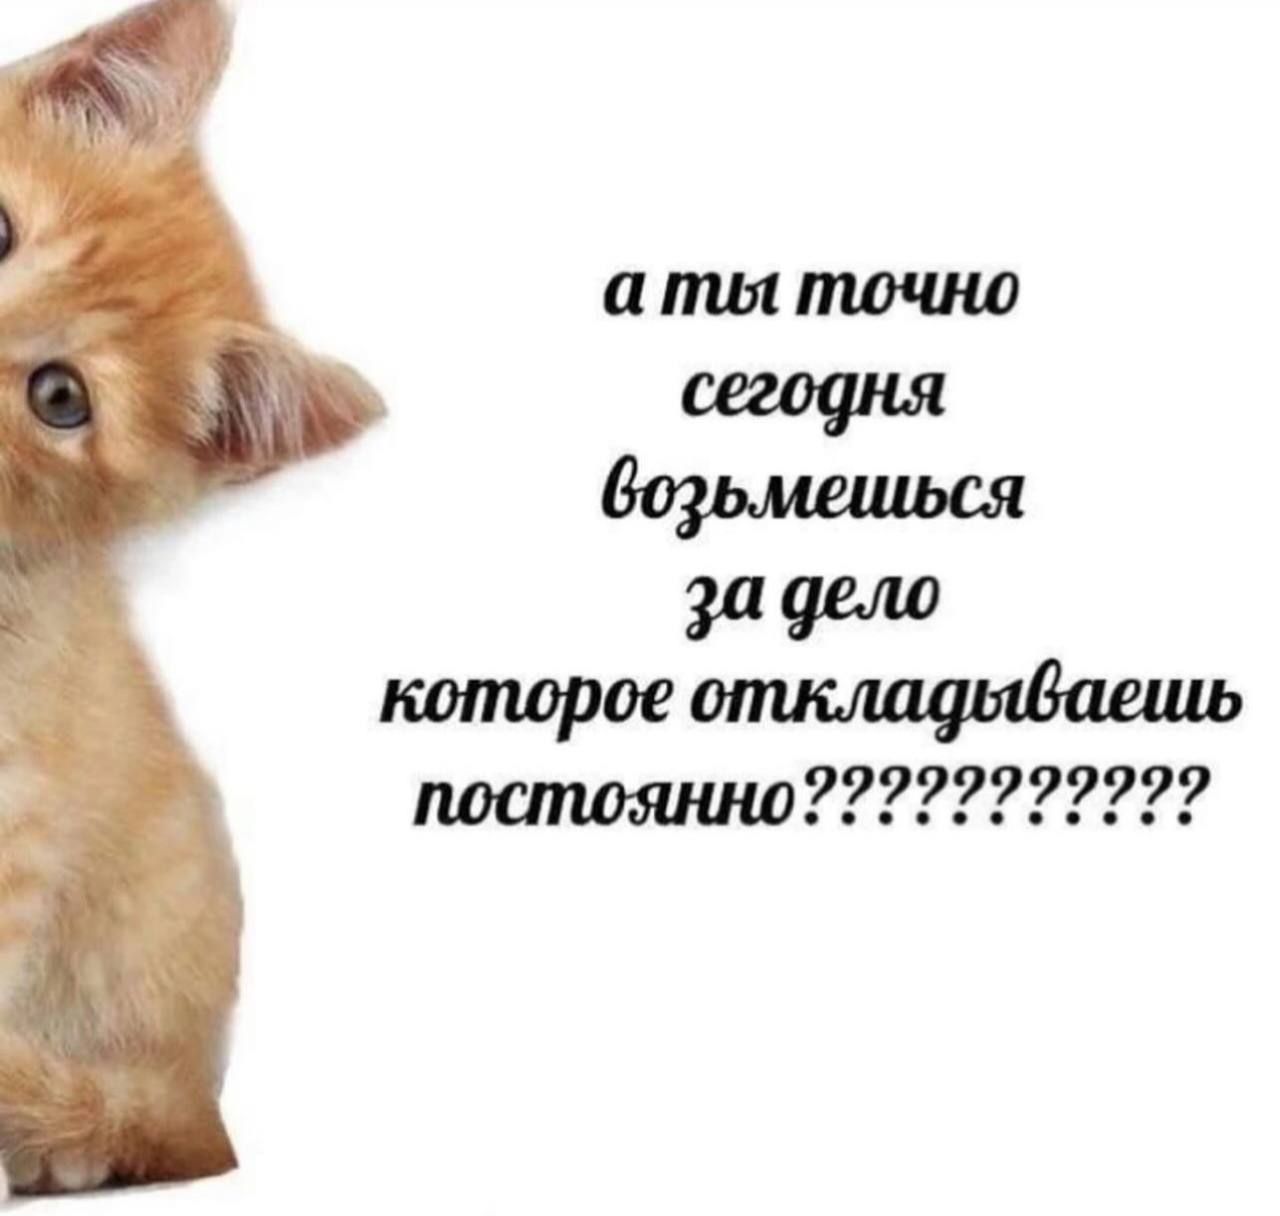

### Сделаю отжиг потом